In [1]:
## Import required libraries
import numpy as np
import pandas as pa
import seaborn as sn 

import nltk
from nltk.tokenize import word_tokenize,sent_tokenize,TweetTokenizer
import string
import re
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')
tokneizer = TweetTokenizer()
lem = WordNetLemmatizer()
engstopwords = set(stopwords.words('english'))
random_state = 42


In [2]:
## Read data
train = pa.read_csv('train.csv')
test = pa.read_csv('test.csv')


In [3]:
##Meta Features 
def preprocessing(data):
    #word
    data['len_words'] = data['text'].apply(lambda x:len(str(x).split()))
    #charachter
    data['max_char'] = data['text'].apply(lambda x:len(str(x)))
    #punctuation
    data['total_punc'] = data['text'].apply(lambda x: len([punc for punc in str(x) if punc in string.punctuation]))
    #uppercase
    data['upper_case'] = data['text'].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))
    #stopwords
    data['total_stopwords'] = data['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in engstopwords]))
    #avg length of each words
    data['avg_length'] = data['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    #unique words in text
    data['unique_words'] = data['text'].apply(lambda x:len(set(str(x).split())))
    #avg unique words in text
    data['avg_unique_words'] = data['text'].apply(lambda x:np.mean([len(word) for word in set(str(x).split())]))

    return data

In [4]:
##Add the meta features
train = preprocessing(train)
test = preprocessing(test)

APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}


In [5]:
punctuation = string.punctuation

def data_cleaning(data):
    ##convert to lower case
    data_lower = data.lower()
    ##word tokenize using tweet tokenizer
    words = tokneizer.tokenize(data_lower)
    ##convert appos
    words = [APPO[word] if word in APPO else word for word in words]
    ##remove the stopwords
    words = [word for word in words if not word in engstopwords]
    ##lemmaize
    words = [lem.lemmatize(word,'v')  for word in words]
    ##remove punctuation
    words = [word for word in words if not word in punctuation]
    
    clean_sent = " ".join(words)
    return clean_sent

In [6]:
cleaned_train = train['text'].apply(lambda x:data_cleaning(x))
cleaned_test = test['text'].apply(lambda x:data_cleaning(x))


In [50]:

#cleaned train and test data
train['text'] = cleaned_train.values
test['text'] = cleaned_test.values


In [64]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train['author'].map(author_mapping_dict)
train_id = train['id']

In [85]:
test_x = test[meta_features]

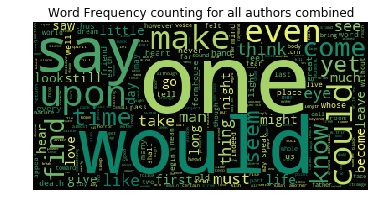

In [54]:
text = train['text'].values
wc = WordCloud(background_color='black',max_words=400,stopwords=engstopwords)
wc.generate(" ".join(text))
plt.axis('off')
plt.title("Word Frequency counting for all authors combined")
plt.imshow(wc.recolor(colormap='summer',random_state=42),alpha=0.98)

In [66]:
meta_features =['len_words','max_char','total_punc','upper_case','total_stopwords','avg_length','unique_words','avg_unique_words']
train_meta_features = train[meta_features]


In [91]:
##split the data
def XGBoost(x_train,y_train,x_test,y_test,x_original_test):
    num_rounds = 1000
    #model = XGBClassifier(num_class=3,objective='multi:softprob',silent=1)
    #crossvaildation using gridsearch cv
    '''params ={'learning_rate':[0.1,0.09],
                  'max_depth':[3,5,6],
                  'n_estimators':[100,150,200],
                  'min_child_weight':[1,2,3],
                  'colsample_bytree':[0.3,0.5,1]}'''
    
    #gridsearh = GridSearchCV(model,param_grid=params,cv=5,scoring='f1_weighted')
    #grid_xgb = gridsearh.fit(x_train,y_train)
    #print("Best scores is",grid_xgb.best_score_)
    #print("Best parameter is",grid_xgb.best_estimator_)


    #best parameters
    #best_model = grid_xgb.best_estimator_
    '''best_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.09, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=1, subsample=1, verbosity=1)'''
    
    
    #train the model
    xgtrain = xgb.DMatrix(x_train,label=y_train)
    xgtest = xgb.DMatrix(x_test,label=y_test)
    xgotest = xgb.DMatrix(x_original_test)
    
    watchlist = [(xgtrain,'train'),(xgtest,'test')]
    
    params ={'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
              'colsample_bynode':1, 'colsample_bytree':1, 'gamma':0,
              'learning_rate':0.09, 'max_delta_step':0, 'max_depth':5,
              'min_child_weight':3, 'missing':None, 'n_estimators':200, 'n_jobs':1,
              'nthread':0, 'num_class':3, 'objective':'multi:softprob',
              'random_state':42, 'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1,
              'seed':0,'eval_metric':'mlogloss' ,'silent':1, 'subsample':1, 'verbosity':1}
    
    plst = list(params.items())
    xgmodel = xgb.train(plst,xgtrain,num_rounds,watchlist,early_stopping_rounds=50,verbose_eval=20)
    pred_x_test = xgmodel.predict(xgtest,ntree_limit=xgmodel.best_ntree_limit)
    pred_xo_test = xgmodel.predict(xgotest,ntree_limit=xgmodel.best_ntree_limit)
    
    return pred_x_test,pred_xo_test,xgmodel   
    
    
    
    #model accuracy
    #predicted result confusing martrix and auc roc if needed 
    pass

In [92]:
X_train,X_test,Y_train,Y_test = train_test_split(train_meta_features,train_y,test_size=0.3,random_state=random_state)

In [93]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)
pred_test_full = 0
cv_score = []
i=1

In [94]:
for train_index,test_index in kf.split(train_meta_features):
    print('{} in K Fold {}'.format(i,kf.n_splits))
    xtrain,xvalid = train_meta_features.loc[train_index],train_meta_features.loc[test_index]
    ytrain,yvalid = train_y[train_index],train_y[test_index]
    
    pred_valid_test,pred_original_test,xgmodel = XGBoost(xtrain,ytrain,xvalid,yvalid,test[meta_features])
    pred_test_full +=pred_original_test
    cv_score.append(xgmodel.best_score)
    i+=1


1 in K Fold 5
[0]	train-mlogloss:1.08706	test-mlogloss:1.08949
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.990808	test-mlogloss:1.02498
[40]	train-mlogloss:0.9613	test-mlogloss:1.0134
[60]	train-mlogloss:0.941905	test-mlogloss:1.00941
[80]	train-mlogloss:0.928337	test-mlogloss:1.00784
[100]	train-mlogloss:0.91707	test-mlogloss:1.00631
[120]	train-mlogloss:0.906522	test-mlogloss:1.00546
[140]	train-mlogloss:0.896067	test-mlogloss:1.00519
[160]	train-mlogloss:0.886646	test-mlogloss:1.00591
[180]	train-mlogloss:0.878153	test-mlogloss:1.00633
Stopping. Best iteration:
[132]	train-mlogloss:0.899917	test-mlogloss:1.00511

2 in K Fold 5
[0]	train-mlogloss:1.08785	test-mlogloss:1.08875
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.996331	test